# Objective: 
Analyze ~500,000 food reviews from Amazon, using natural language processing technique Bag of words and TFIDF, and Naive Bayes ML algorithm

## data source: 
https://www.kaggle.com/snap/amazon-fine-food-reviews

1. Number of reviews: 568,454
2. Number of users: 256,059
3. Number of products: 74,258
4. Timespan: Oct 1999 - Oct 2012
5. Number of Attributes/Columns in data: 10 
6. Attribute Information:
    1. Id
    2. ProductId - unique identifier for the product
    3. UserId - unqiue identifier for the user
    4. ProfileName
    5. HelpfulnessNumerator - number of users who found the review helpful
    6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    7. Score - rating between 1 and 5
    8. Time - timestamp for the review
    9. Summary - brief summary of the review
    10. Text - text of the review
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the sqlite and pandas to read and analyse the data.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [51]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
import re
from nltk.corpus import stopwords
import nltk
# nltk.download('stopwords')
import time
# import umap
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import scikitplot as skplt
import gensim
from datetime import timedelta
import os

In [12]:
os.chdir("data source/")

In [13]:
os.getcwd()

'C:\\Users\\kali\\Desktop\\git\\amazon-fine-food-reviews-analysis\\data source'

In [14]:
#establishing the sql connection
amazon_df_con = sql.connect('database.sqlite')

#reading the data from sql connection
amazon_df = pd.read_sql("SELECT * FROM Reviews WHERE Score!= 3", con=amazon_df_con)

print("size of our dataset is", amazon_df.shape)
amazon_df.head()

size of our dataset is (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [15]:
#lets consider every review having score greater than 3 as positive
# and less than 3 as negative 
amazon_df['Score'] = amazon_df.Score.apply(lambda x: 'Positive' if x>3 else 'Negative')

# seeing the first 5 rows of amazon_df dataframe
amazon_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [16]:
amazon_df.Score.unique()

array(['Positive', 'Negative'], dtype=object)

In [17]:
print("size of our data is", amazon_df.shape)
print("")
amazon_df.info()

size of our data is (525814, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525814 entries, 0 to 525813
Data columns (total 10 columns):
Id                        525814 non-null int64
ProductId                 525814 non-null object
UserId                    525814 non-null object
ProfileName               525814 non-null object
HelpfulnessNumerator      525814 non-null int64
HelpfulnessDenominator    525814 non-null int64
Score                     525814 non-null object
Time                      525814 non-null int64
Summary                   525814 non-null object
Text                      525814 non-null object
dtypes: int64(4), object(6)
memory usage: 40.1+ MB


We can see that we have total 525814 data points with 10 features

Score Feature contains two values, either Positive or Negative and it is our target variable

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

Lets see whether any duplicate observations are there in the data and delete them, so that we get unbiased results for the analysis of the data

In [18]:
# lets sort the data based on the time
amazon_df = amazon_df.sort_values('Time')

#lets drop the duplicate datpoints
amazon_df.duplicated().sum()

0

from above we can see that there are no exact duplicate observations. 
<p>
but lets see whether there are any observations having same duplicate features like Text, productId, and Time and UserId while having the remaining features different.
</p>
<p>
Because there can't be any review with same Text and UserId with different productId and also no single User can post the same review(Text) at two different times.</p>
So above subduplicates will also be considered as duplicates and we will delete them for further analysis

In [19]:
print(amazon_df.duplicated(subset=['ProductId', 'Text']).sum())
print(amazon_df.duplicated(subset=['ProductId', 'Time', 'Text']).sum())
print(amazon_df.duplicated(subset=['UserId', 'Time', 'Text']).sum())

1242
1130
161681


From above we can see that there are duplicates with same ProductId, Text, UserId
<p>
Out of the obove 3 filters, there are 161681 observations with same UserId, Time, and Text which means that same user has posted same Text at same Time, which is unlikely to happen, so lets delete the above duplicates.
</p>


In [20]:
#so there are no exact duplicate rows
#lets remove the datapoints having the same productId and Time and UserId
amazon_df = amazon_df.drop_duplicates(subset=['ProductId','Time','UserId'])
amazon_df = amazon_df.drop_duplicates(subset=['ProductId','Time','Text'])
amazon_df = amazon_df.drop_duplicates(subset=['UserId','Time','Text'])

In [21]:
amazon_df.duplicated(subset=['UserId','Time','Text']).sum()

0

Now lets see whether there are any observations which has helpfulness numerator feature greater than helpfulness denominator, and delete those observations

In [22]:
amazon_df.query('HelpfulnessNumerator>HelpfulnessDenominator')

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
41159,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,Positive,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
59301,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,Positive,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


In [23]:
# so lets remove the above two observations
num_great = amazon_df.query('HelpfulnessNumerator>HelpfulnessDenominator')
amazon_df = amazon_df.drop(num_great.index)

In [24]:
amazon_df.query('HelpfulnessNumerator>HelpfulnessDenominator')

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


In [25]:
print(amazon_df.loc[215861])
amazon_df.loc[215861]['Text']

Id                                                                   233939
ProductId                                                        B003E6COMO
UserId                                                       A2ZE58VIDDCMR7
ProfileName                                                            inna
HelpfulnessNumerator                                                      1
HelpfulnessDenominator                                                    2
Score                                                              Positive
Time                                                             1350000000
Summary                   &#1091;&#1076;&#1086;&#1073;&#1085;&#1072;&#11...
Text                      &#1056;&#1077;&#1096;&#1080;&#1083;&#1072; &#1...
Name: 215861, dtype: object


'&#1056;&#1077;&#1096;&#1080;&#1083;&#1072; &#1079;&#1072;&#1082;&#1072;&#1079;&#1072;&#1090;&#1100; &#1101;&#1090;&#1080; &#1078;&#1077;&#1083;&#1072;&#1090;&#1080;&#1085;&#1082;&#1080;, &#1090;.&#1082;. &#1076;&#1086;&#1095;&#1082;&#1072; &#1087;&#1086;&#1096;&#1083;&#1072; &#1074; &#1096;&#1082;&#1086;&#1083;&#1091; &#1080; &#1090;&#1088;&#1077;&#1073;&#1091;&#1077;&#1090; &#1089;&#1083;&#1072;&#1076;&#1086;&#1089;&#1090;&#1080;. &#1054;&#1095;&#1077;&#1085;&#1100; &#1091;&#1076;&#1086;&#1073;&#1085;&#1072;&#1103; &#1091;&#1087;&#1072;&#1082;&#1086;&#1074;&#1082;&#1072;. &#1050;&#1072;&#1082; &#1088;&#1072;&#1079; &#1089;&#1090;&#1086;&#1083;&#1100;&#1082;&#1086; &#1082;&#1086;&#1085;&#1092;&#1077;&#1090;, &#1082;&#1072;&#1082; &#1080; &#1090;&#1088;&#1077;&#1073;&#1091;&#1077;&#1090;&#1089;&#1103;, &#1095;&#1090;&#1086;&#1073;&#1099; &#1089;&#1100;&#1077;&#1089;&#1090;&#1100; &#1080;&#1093; &#1079;&#1072; &#1087;&#1077;&#1088;&#1077;&#1084;&#1077;&#1085;&#1091;.'

In [26]:
# As we can say from above that 215861 indexed row has invalid text and summary, lets drop that row also
amzon_df = amazon_df.drop(215861)

In [27]:
print("so we are left with {} observations and {} features".format(amazon_df.shape[0], amazon_df.shape[1]))

so we are left with 363960 observations and 10 features


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

In [28]:
for sent in amazon_df['Text'].values[50:52]:
    if len(re.findall('<.*?>', sent)):
        print(sent)

Long live Camper Van Beethoven!! This is a blessing for long time CVB fans who didn't have a chance to upgrade their collection to CD before most of this went out of print.  Wow, where to begin?  CVB was a band that matured on record, so to speak, so this is really a fascinating and entertaining listen from beginning to end.<br />  Of course you get the endearing and humorous debut album with goofy anthems ala "Take the Skinheads Bowling" and various folk/ska instrumentals; the increasingly warped and psychedelic "II & III"; and this collections' centerpiece: the self titled 3rd album!!  Forget the editorial remark above about them "scratching their heads out loud" on this because there's nothing confused, unfocused, or tentative about this album.  I'd say it's a characteristically irreverent and eclectic psych-rock masterpiece.  The song writing has fully matured with the sarcastic humor still intact, and it seems to be intentionally conceived as an album that gets stranger and strang

So lets import the stop words and also write functions for removing and html tags, and punctuations

In [29]:
stopw = set(stopwords.words('english'))
snow = nltk.stem.SnowballStemmer('english')
# lets remove words like not, very from stop words as they are meaninging in the reviews 
reqd_words = set(['only','very',"doesn't",'few','not'])
stopw = stopw - reqd_words

In [30]:
def clean_html(review):
    '''This function cleans html tags if any
    , in the review'''
    
    cleaner = re.compile('<.*?>')
    clean_txt  = re.sub(cleaner, ' ', review)
    return clean_txt

def cleanpunc(sentence): 
    '''function to clean the word of any punctuation
    or special characters'''
    
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stopw)
print('****************************')
print(snow.stem('beautiful'))

{'of', "you're", 'their', "hasn't", 'a', 'ain', 'at', 'be', 'than', 'should', 'you', 'both', 'them', 'his', 'this', 'wasn', 'there', 'with', 'those', 'as', "shouldn't", 'in', "weren't", 'wouldn', 'her', 'couldn', 'nor', 'having', 'its', 'didn', 'through', 'had', 'that', 'mightn', 'during', 'myself', 'any', "needn't", 'these', 'he', 'were', "mustn't", 'yourselves', "aren't", "isn't", 'into', 'yours', 'who', "you'd", 'needn', 'been', "you'll", 'can', "you've", "don't", "she's", 'here', 'itself', 'yourself', 'they', 'our', 'shan', 'themselves', 't', 'she', 'below', 'don', "wouldn't", 'more', 'then', 'hasn', 'because', 's', 'shouldn', 'against', 'so', 'too', 'each', 'and', 'hers', 'before', "it's", 'by', 'until', 'over', 'an', 'once', "couldn't", 'from', 'other', 'above', 'was', 'all', 'are', 'if', 'isn', "won't", 'off', 'weren', 'does', 'hadn', 'for', 'mustn', "shan't", 'd', 'has', 'now', 'which', 'where', 'himself', 'your', 'herself', 'some', 'the', 'under', "hadn't", 'o', 'same', 'is', 

To analyze the reviews and convert to vectors lets perform the following steps

1. iterating through each of the review(# 1st loop)
2. cleaning any html content of the review 
3. splitting individually all the words of the review into a list 
4. apply cleanpunc function on each word of the list so that we can remove if any punctiations are there
5. checking whether the cleaned word is there in the stop words
6. add the word to the new list if the cleaned word is not the stop words, and it is alphabetic and length is greater than 2
7. Separately store all the positve words and negative words in two separate lists
8. now make whole new list into a string
9. the new string is the processed review

In [31]:
final_cleaned_reviews = []
all_positive_words = []
all_negative_words = []
start_time = time.time()
for i,review in enumerate(amazon_df['Text'].values):
    review_filtered_words = []
    html_free = clean_html(review)
    for h_free_word in html_free.split():
        for clean_word in cleanpunc(h_free_word).split():
            if (((clean_word.isalpha()) & (len(clean_word)>2)) & \
                ((clean_word.lower() not in stopw))):
                final_word = snow.stem(clean_word.lower())
                review_filtered_words.append(final_word)
                if amazon_df['Score'].values[i] == 'Positive':
                    all_positive_words.append(final_word)
                else:
                    all_negative_words.append(final_word)
    final_str = " ".join(review_filtered_words)
    final_cleaned_reviews.append(final_str)
end_time = time.time()
print('time took is ', (end_time-start_time))

time took is  752.5657629966736


In [32]:
%%time
# adding the cleaned reviews to dataframe
amazon_df['CleanedText']=final_cleaned_reviews

Wall time: 1.4 s


In [33]:
amazon_df.shape

(363960, 11)

Positive    0.843164
Negative    0.156836
Name: Score, dtype: float64


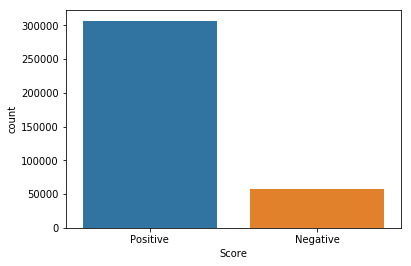

In [146]:
print(amazon_df.Score.value_counts(normalize=True))
sns.countplot(amazon_df.Score);

we can see that there are 84.31 percent positive reviews and 15.68 percent negative reviews, 
<br>
So the amazon fine food reviews dataset is higly imbalanced with postive reviews
</br>
#### Since the dataset is higly imbalanced accuracy is not a good performance metric</li>

#### So we will use ROC AUC, confusion matrix, and precision recall and f1 scores for evaluation of our models</li>

In [101]:
# Now lets split the dataset into train, validation and test dataset
train_df = amazon_df[:120000]
cv_df = amazon_df[120000:160000]
test_df = amazon_df[160000:200000]

In [102]:
train_df.shape, test_df.shape, cv_df.shape

((120000, 11), (40000, 11), (40000, 11))

# [4] Featurization

## [4.1] BAG OF WORDS

### converting text into vectors using BOW unigram

In [147]:
count_vect = CountVectorizer(min_df=10, max_features=10000)
unigram_xtrain_vect = count_vect.\
fit_transform(train_df.CleanedText)

unigram_xtest_vect = count_vect.transform(test_df.CleanedText)

unigram_xcv_vect = count_vect.transform(cv_df.CleanedText)

In [148]:
print(unigram_xtrain_vect.shape, unigram_xcv_vect.shape, unigram_xtest_vect.shape)

(120000, 9140) (40000, 9140) (40000, 9140)


## [4.2] Bi-Grams

### converting data into vectors using BOW bigram

In [149]:
bigram_count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=10000)
bigram_xtrain_vect = bigram_count_vect.\
fit_transform(train_df.CleanedText)

bigram_xtest_vect = bigram_count_vect.transform(test_df.CleanedText)

bigram_xcv_vect = bigram_count_vect.transform(cv_df.CleanedText)

In [152]:
bigram_xtrain_vect.shape, bigram_xcv_vect.shape, bigram_xtest_vect.shape

((120000, 10000), (40000, 10000), (40000, 10000))

## [4.3] Tri-Grams

### converting data into vectors using BOW trigrams

In [151]:
trigram_count_vect = CountVectorizer(ngram_range=(1,3), min_df=10, max_features=10000)
trigram_xtrain_vect = trigram_count_vect.\
fit_transform(train_df.CleanedText)

trigram_xtest_vect = trigram_count_vect.transform(test_df.CleanedText)

trigram_xcv_vect = trigram_count_vect.transform(cv_df.CleanedText)

In [153]:
trigram_xtrain_vect.shape, trigram_xcv_vect.shape, trigram_xtest_vect.shape

((120000, 10000), (40000, 10000), (40000, 10000))

## [4.4] TF-IDF

### converting data into vectors using TF-IDF

In [154]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=10000)
tfidf_xtrain_vect = tfidf.\
fit_transform(train_df.CleanedText)

tfidf_xtest_vect = tfidf.transform(test_df.CleanedText)

tfidf_xcv_vect = tfidf.transform(cv_df.CleanedText)

In [155]:
print(tfidf_xtrain_vect.shape, tfidf_xcv_vect.shape, tfidf_xtest_vect.shape)

(120000, 10000) (40000, 10000) (40000, 10000)


# Applying Multinomial Naive Bayes

Lets write a function which does the following things using Multinomial Naive Bayes:
<ol>
    <li> find the optimal alpha using the train and validation dataset </li>
    <li> Plotting the confusion matrix and precision recall f1 score on validation dataset</li>
    <li> plot the ROC AUC curve using optimal alpha on validation dataset </li>
    <li> Fit the Multinomial Naive Bayes on train dataset using optmial alpha
        and Predict on test dataset</li> 
    <li> Plot the confusion matrix, precision recall values </li>
    <li> Plot the ROC AUC curve on test dataset values</li>
</ol>

In [158]:
np.log([0.001,0.45,0.94])

array([-6.90775528, -0.7985077 , -0.0618754 ])

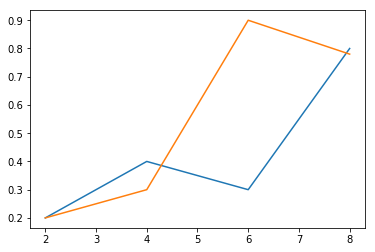

In [188]:
plt.plot([2,4,6,8],[0.2,0.4,0.3,0.8])
plt.plot([2,4,6,8],[0.2,0.3,0.9,0.78])

In [ ]:
def mnb_model(x_train, y_train, x_cv, y_cv, x_test, y_test, algo,step):
    '''this function uses the validation dataset to find the optimal k 
    and uses the optimal k and trained algorithm to predict the test data'''
    
    ##finding the optimal alpha using validation dataset
    print('------------------------------------------------------------')
    print('started finding the optimal alpha for MultinomialNB algorithm')
    alpha_values = list(np.logspace(np.log(0.00005), np.log(10000), base = np.exp(1), num = 20))
    train_auc = []
    auc = []
    best_cv_predict = 0
    best_fpr = 0
    best_tpr= 0
    for a in alpha_values:
        mnb = MultinomialNB(alpha=a)
        mnb.fit(x_train, y_train)
        #cv_predict = knn.predict(x_cv)
        #if you have enough ram run above code otherwise run below
        predicted_labels = []
        predicted_prob = []
        train_predicted_labels = []
        train_predicted_prob = []
        
        for i in range(0, x_cv.shape[0], 500):
            predicted_labels.extend(mnb.predict(x_cv[i:i+500]))
            predicted_prob.extend(mnb.predict_proba(x_cv[i:i+500]))
            
        for i in range(0, x_train.shape[0], 500):
            train_predicted_labels.extend(mnb.predict(x_train[i:i+500]))
            train_predicted_prob.extend(mnb.predict_proba(x_train[i:i+500]))
            
        cv_predict = np.array(predicted_labels)
        cv_predict_proba = np.array(predicted_prob)
        train_predict = np.array(train_predicted_labels)
        train_predict_proba = np.array(train_predicted_prob)
        
        fpr, tpr, thresholds = metrics.roc_curve(y_cv, [x[1] for x in predicted_prob], pos_label='Positive')
        t_fpr, t_tpr, t_thresholds = metrics.roc_curve(y_train, [x[1] for x in train_predict_proba], pos_label='Positive')
        auc_score = metrics.auc(fpr, tpr)
        t_auc_score = metrics.auc(t_fpr, t_tpr)
        #acc_score = accuracy_score(y_cv, cv_predict)
        auc.append(auc_score)
        train_auc.append(t_auc_score)
        if auc_score >= max(auc):
            best_cv_predict = cv_predict
            best_cv_predict_proba = cv_predict_proba
            best_fpr = fpr
            best_tpr = tpr
            print('as of now best alpha is {} with AUC score of {}'.format(a, auc_score))
        
    plt.figure(figsize=(16,4))
    plt.plot(np.log(alpha_values), auc, label='validation AUC');
    plt.plot(np.log(alpha_values), train_auc, label='train AUC');
    plt.xticks(np.log(alpha_values));
    plt.xlabel("log(alpha values)")
    plt.ylabel("auc score")
    plt.legend();
    plt.title('auc score on train dataset and validation dataset with different alpha values');
    plt.show()    
    
    optimal_alpha = alpha_values[auc.index(max(auc))]
    print('alpha value which is giving highest AUC value of {} on cross vadiation dataset is {}'.format(max(auc), optimal_alpha))
    
    # AUC curve on this optimal alpha value on crossvalidation dataset
    # ROC AUC PLOT
    print('ROC plot with best alpha value on cross validation dataset')
    skplt.metrics.plot_roc(y_cv, best_cv_predict_proba, title='ROC Curves on validation dataset')
    plt.show()
    
    #confusion matrix of this optimal neighbour on crossvalidation dataset
    cv_cm = pd.crosstab(y_cv, best_cv_predict, rownames=["actual Score"], colnames=["predicted Score"], normalize=True)
    sns.heatmap(cv_cm, annot=True, fmt=".4f")
    plt.title('Confusion matrix on validation dataset with best parameters');
    plt.show()
    
    print('precission recall and f score on best optimal alpha predicted data of validation dataset is')
    print(classification_report(y_cv, best_cv_predict))
    print('------------------------------------------------------------------------------')
    
    # trainning the algorithm on train data and testing on the test data
    print('training the algoritm using train data and predicting on the test dataset')
    # x_train_valid = np.vstack((x_train, x_cv))
    # y_train_valid = np.hstack((y_train, y_cv))
    t_mnb = MultinomialNB(alpha=optimal_alpha)
    t_mnb.fit(x_train, y_train)
    #test_predict = knn.predict(x_test)
    
    predicted_list = []
    predicted_prob_list = []
    for i in range(0, x_test.shape[0], 500):
        predicted_list.extend(t_mnb.predict(x_test[i:i+500]))
        predicted_prob_list.extend(t_mnb.predict_proba(x_test[i:i+500]))
        
            
    test_predict = np.array(predicted_list)
    test_predict_proba = np.array(predicted_prob_list)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, [x[1] for x in predicted_prob_list], pos_label='Positive')
    auc_score = metrics.auc(fpr, tpr)
    
    #print('accuracy score on test data is {}'.format(accuracy_score(y_test, test_predict)))
    print('AUC score on test data is {}'.format(auc_score))
    
    #ROC plot on test dataset
    skplt.metrics.plot_roc(y_test, test_predict_proba, title='ROC Curves on test dataset') 
    plt.show()
    
    #confusion matrix on test dataset
    test_cm = pd.crosstab(y_test, test_predict, rownames=["actual Score"], colnames=["predicted Score"], normalize=True)
    sns.heatmap(test_cm, annot=True, fmt=".4f")
    plt.title('Confusion matrix on test dataset with best parameters');
    plt.show()
    
    print('precission recall and f score using best optimal alpha predicted data on test dataset is')
    print(classification_report(y_test, test_predict))
    return t_mnb.feature_log_prob_

## [5.1] Applying Naive Bayes on BOW unigram,<font color='red'> SET 1</font>

------------------------------------------------------------
started finding the optimal alpha for MultinomialNB algorithm
as of now best alpha is 5.000000000000007e-05 with AUC score of 0.8979668261607996
as of now best alpha is 0.00013673078900308913 with AUC score of 0.8998645187447889
as of now best alpha is 0.00037390617322814436 with AUC score of 0.9018673468350022
as of now best alpha is 0.0010224897215721964 with AUC score of 0.9039663936537986
as of now best alpha is 0.0027961165275623007 with AUC score of 0.9061572942175394
as of now best alpha is 0.007646304379163406 with AUC score of 0.9083934917383161
as of now best alpha is 0.02090970461441573 with AUC score of 0.9105694656982999
as of now best alpha is 0.057180008195011796 with AUC score of 0.9125634316870765
as of now best alpha is 0.15636535271414095 with AUC score of 0.9143365103670822
as of now best alpha is 0.4275991609870157 with AUC score of 0.9157761895008711
as of now best alpha is 1.169319413176268 with AUC sco

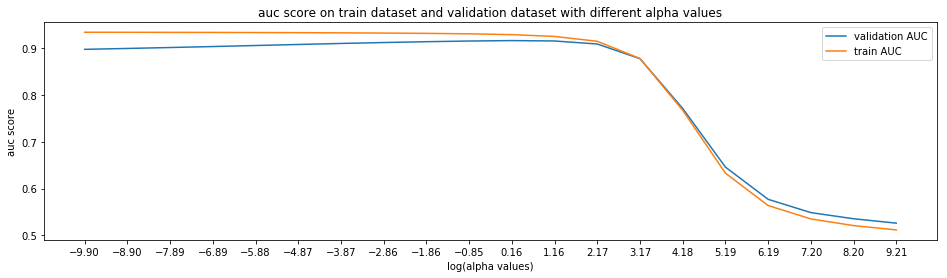

alpha value which is giving highest AUC value of 0.9167118018732651 on cross vadiation dataset is 1.169319413176268
ROC plot with best alpha value on cross validation dataset


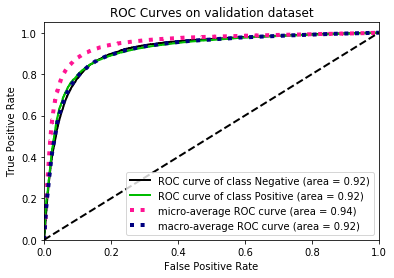

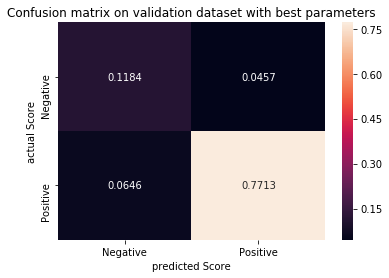

precission recall and f score on best optimal alpha predicted data of validation dataset is
              precision    recall  f1-score   support

    Negative       0.65      0.72      0.68      6564
    Positive       0.94      0.92      0.93     33436

   micro avg       0.89      0.89      0.89     40000
   macro avg       0.80      0.82      0.81     40000
weighted avg       0.90      0.89      0.89     40000

------------------------------------------------------------------------------
training the algoritm using train data and predicting on the test dataset
accuracy score on test data is 0.889625
AUC score on test data is 0.9141009308333796


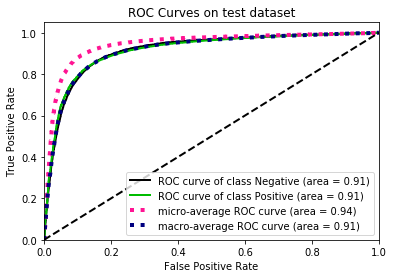

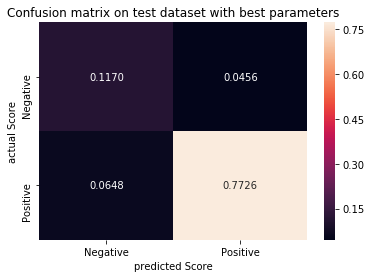

precission recall and f score using best optimal alpha predicted data on test dataset is
              precision    recall  f1-score   support

    Negative       0.64      0.72      0.68      6501
    Positive       0.94      0.92      0.93     33499

   micro avg       0.89      0.89      0.89     40000
   macro avg       0.79      0.82      0.81     40000
weighted avg       0.90      0.89      0.89     40000

Wall time: 59.6 s


In [214]:
%%time
unigram_feature_lob_probs = mnb_model(x_train=unigram_xtrain_vect, y_train=train_df.Score, x_cv=unigram_xcv_vect, y_cv=cv_df.Score, x_test=unigram_xtest_vect, y_test=test_df.Score, algo='brute', step=4)

In [ ]:
unigram_feature_lob_probs

In [ ]:
print("hi")

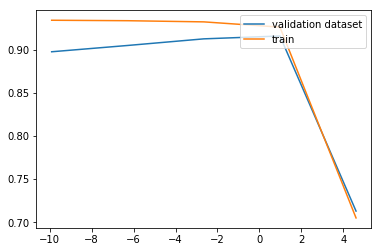

In [207]:
plt.plot(np.log(a), au, label='validation dataset')
plt.plot(np.log(a), tau, label='train')
plt.legend(loc='upper right');

### [5.1.1] Top 10 important features of positive class from unigram<font color='red'> SET 1</font>

### [5.1.2] Top 10 important features of negative class from unigram <font color='red'> SET 1</font>

## [5.2] Applying Naive Bayes on bigram,<font color='red'> SET 1</font>

In [143]:
%%time
mnb_model(x_train=bigram_xtrain_vect, y_train=train_df.Score, x_cv=bigram_xcv_vect, y_cv=cv_df.Score, x_test=bigram_xtest_vect, y_test=test_df.Score, algo='brute', step=4)

### [5.2.1] Top 10 important features of positive class from bigram<font color='red'> SET 1</font>

### [5.2.2] Top 10 important features of negative class from bigram<font color='red'> SET 1</font>

## [5.3] Applying Naive Bayes on trigram,<font color='red'> SET 1</font>

In [ ]:
%%time
mnb_model(x_train=trigram_xtrain_vect, y_train=train_df.Score, x_cv=trigram_xcv_vect, y_cv=cv_df.Score, x_test=trigram_xtest_vect, y_test=test_df.Score, algo='brute', step=4)

### [5.3.1] Top 10 important features of positive class from trigram<font color='red'> SET 1</font>

### [5.3.2] Top 10 important features of negative class from trigram<font color='red'> SET 1</font>

## [5.4] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [ ]:
%%time
mnb_model(x_train=tfidf_xtrain_vect, y_train=train_df.Score, x_cv=tfidf_xcv_vect, y_cv=cv_df.Score, x_test=tfidf_xtest_vect, y_test=test_df.Score, algo='brute', step=4)

### [5.4.1] Top 10 important features of positive class from TFIDF<font color='red'> SET 2</font>

### [5.4.2] Top 10 important features of negative class from TFIDF<font color='red'> SET 2</font>